<a href="https://colab.research.google.com/github/NickBourdeau/DS2020/blob/master/Model_Optimization_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Optimization and Evaluation

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, LeaveOneOut

df = pd.read_csv('credit_card.csv')
df = df.drop(columns=['ID'])
df.rename(columns={'default payment next month': 'Default'}, inplace=True)

In [0]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Regressor Selection 

Heatmap to find best covariates

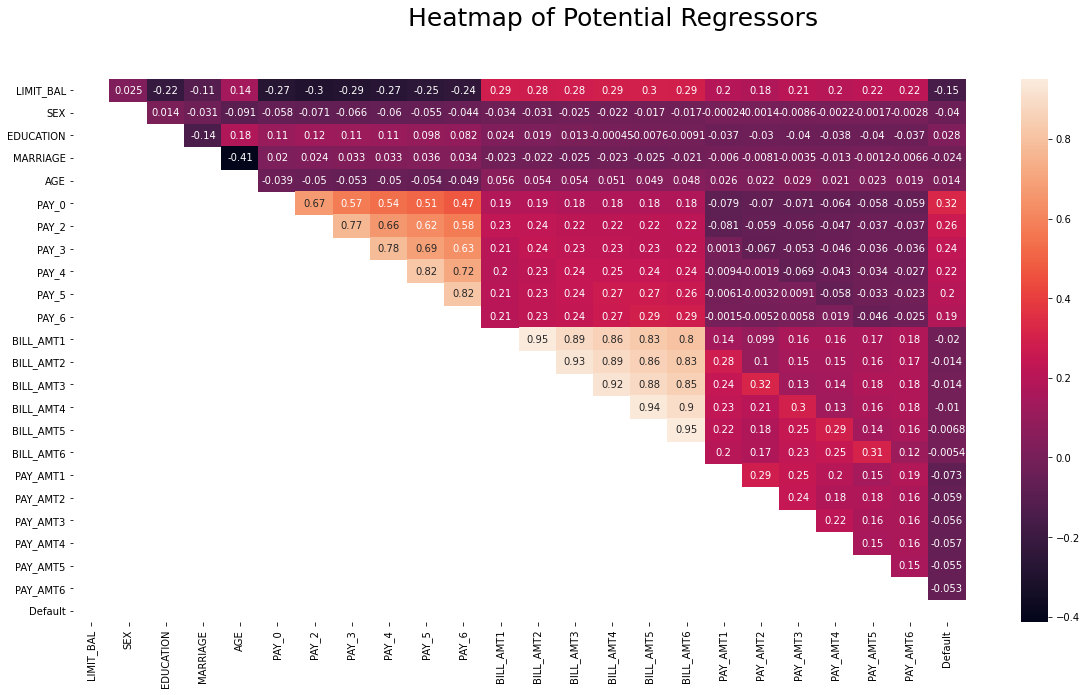

In [0]:
plt.figure(figsize=[20, 10])
sns.heatmap(df.corr(), annot=True, fmt='.2g', mask=np.tril(df.corr()));
plt.suptitle('Heatmap of Potential Regressors', fontsize=25);

Regressor Selection

In [0]:
df.corr()[['Default']].sort_values(ascending=False, by='Default').head() # use PAY_0 and PAY_1

x_2_regressors = df[['PAY_0', 'PAY_2']]
y_2_regressors = df.iloc[:, -1]

x_3_regressors = df[['PAY_0', 'PAY_2', 'PAY_3']]
y_3_regressors = df.iloc[:, -1]

In [0]:
pay_groups = df.groupby(['Default', 'PAY_0']).count()[['LIMIT_BAL']] / df.groupby('Default').count()[['LIMIT_BAL']]
pay_groups = pay_groups.reset_index()
pay_groups.rename(columns={'LIMIT_BAL': 'proportion'}, inplace=True)
pay_groups

pay2_groups = df.groupby(['Default', 'PAY_2']).count()[['LIMIT_BAL']] / df.groupby('Default').count()[['LIMIT_BAL']]
pay2_groups = pay2_groups.reset_index()
pay2_groups.rename(columns={'LIMIT_BAL': 'proportion'}, inplace=True)
pay2_groups

,Default,PAY_2,proportion
0,0,-2,0.132298
1,0,-1,0.217600
2,0,0,0.566127
3,0,1,0.000984
4,0,2,0.074602
5,0,3,0.005350
6,0,4,0.002097
7,0,5,0.000428
8,0,6,0.000128
9,0,7,0.000342


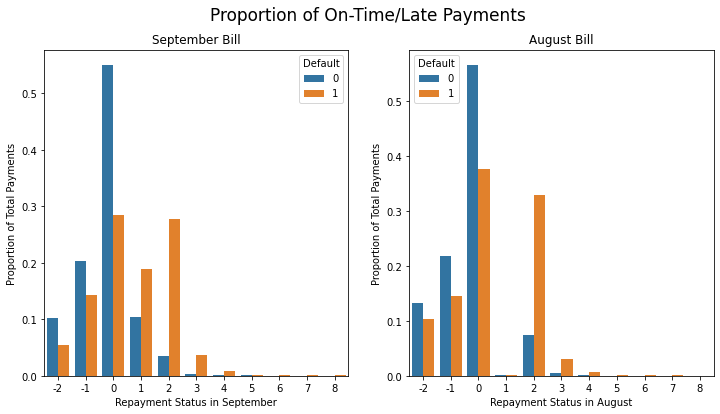

In [0]:
f, axes = plt.subplots(1, 2, figsize=(12,6))
sns.barplot(x='PAY_0', y='proportion', hue='Default', data = pay_groups, ax = axes[0]);
axes[0].title.set_text('September Bill')
axes[0].set_xlabel('Repayment Status in September')
axes[0].set_ylabel('Proportion of Total Payments')

sns.barplot(x='PAY_2', y='proportion', hue='Default', data = pay2_groups, ax=axes[1]);
axes[1].title.set_text('August Bill')
axes[1].set_xlabel('Repayment Status in August')
axes[1].set_ylabel('Proportion of Total Payments')
  
plt.suptitle('Proportion of On-Time/Late Payments', fontsize=17);


## Why are late payments so prevalent in september as opposed to other months?

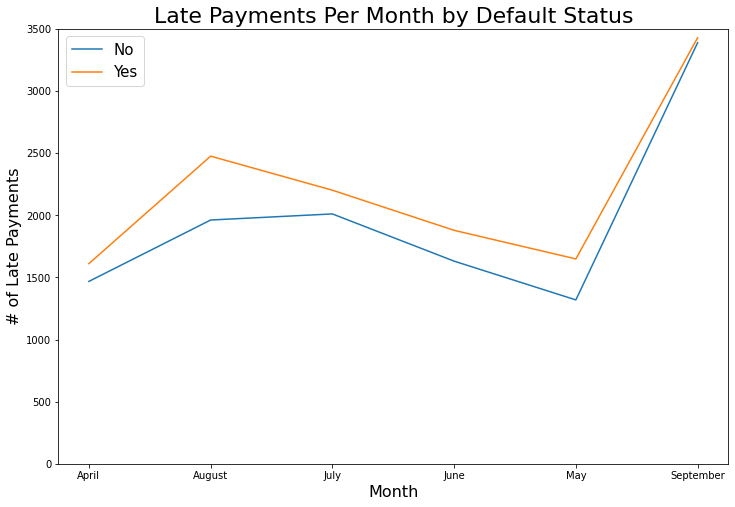

In [0]:
df_long = df.melt(id_vars=df[['Default']], value_vars=df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']], value_name='repayment_status')

late_payments_by_month = df_long[df_long.repayment_status > 0].groupby('variable').count().sort_values(ascending=False, by='variable')[['repayment_status']]
late_payments_by_month = late_payments_by_month.assign(Month = ['April', 'May', 'June', 'July', 'August', 'September'])

late_payments_default = df_long[df_long.repayment_status > 0].groupby(['variable', 'Default']).count().sort_values(ascending=False, by='variable')
late_payments_default = late_payments_default.assign(Month = ['April', 'April', 'May', 'May', 'June', 'June', 'July', 'July', 'August', 'August', 'September', 'September'])
late_payments_default = late_payments_default.reset_index()


plt.figure(figsize=[12, 8])
sns.lineplot('Month', 'repayment_status', hue='Default', data=late_payments_default);
plt.ylim(0, 3500);
plt.title('Late Payments Per Month by Default Status', fontsize=22);
plt.ylabel('# of Late Payments', fontsize=16);
plt.xlabel('Month', fontsize=16)
plt.legend(['No', 'Yes'], prop=dict(size=15));
plt.savefig('late_payments.png', format='png', dpi=1200)

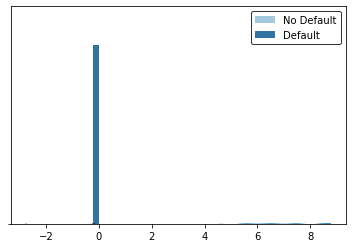

In [0]:
sns.barplot(df[df['Default']==0][['PAY_0']], label = 'Default')
sns.distplot(df[df['Default']==1][['PAY_0']], label='No Default')
pst = plt.legend(loc='upper right', frameon=True)
pst.get_frame().set_edgecolor('k');

# Validation Approach

First Model -- Two Regressors

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_2_regressors, y_2_regressors, test_size = 0.2)

val_model = LogisticRegression().fit(x_train, y_train)
print('Metrics for First Logistic Regression Model with a Single Validation Set:')
print('   Score:', round(val_model.score(x_train, y_train)*100, 2), '%')
val_preds = val_model.predict(x_test)
print('   Accuracy:', round((val_preds == y_test).mean()*100, 2), '%')

Metrics for First Logistic Regression Model with a Single Validation Set:
   Score: 80.84 %
   Accuracy: 81.27 %


Second Model -- Three Regressors

In [0]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_3_regressors, y_3_regressors, test_size = 0.2)

val_model_2 = LogisticRegression().fit(x_train_2, y_train_2)
print('Metrics for Second Logistic Regression Model with a Single Validation Set:')
print('   Score:', round(val_model_2.score(x_train_2, y_train_2)*100, 2), '%')
val_preds_2 = val_model_2.predict(x_test_2)
print('   Accuracy:', round((val_preds_2 == y_test_2).mean()*100, 2), '%')

Metrics for Second Logistic Regression Model with a Single Validation Set:
   Score: 80.57 %
   Accuracy: 80.47 %


# K-Fold Cross Validation

First Model -- Two Regressors

In [0]:
print('Accuracy of First Logistic Regression Model using K-Fold Cross Validation')

k_fold_5_model = LogisticRegression(solver='saga')
k_fold_5_scores = cross_val_score(k_fold_5_model, x_2_regressors, y_2_regressors, cv=5)
print('   5-Fold:', round(k_fold_5_scores.mean()*100, 2), '%')

k_fold_10_model = LogisticRegression(solver='saga')
k_fold_10_scores = cross_val_score(k_fold_10_model, x_2_regressors, y_2_regressors, cv=10)
print('   10-Fold:', round(k_fold_10_scores.mean()*100, 2), '%')

Accuracy of First Logistic Regression Model using K-Fold Cross Validation
   5-Fold: 80.92 %
   10-Fold: 80.93 %


Second Model -- Three Regressors

In [0]:
print('Accuracy of Second Logistic Regression Model using K-Fold Cross Validation')

k_fold_5_model_2 = LogisticRegression(solver='saga')
k_fold_5_scores_2 = cross_val_score(k_fold_5_model_2, x_3_regressors, y_3_regressors, cv=5)
print('   5-Fold:', round(k_fold_5_scores_2.mean()*100, 2), '%')

k_fold_10_model_2 = LogisticRegression(solver='saga')
k_fold_10_scores_2 = cross_val_score(k_fold_10_model_2, x_3_regressors, y_3_regressors, cv=10)
print('   10-Fold:', round(k_fold_10_scores_2.mean()*100, 2), '%')

Accuracy of Second Logistic Regression Model using K-Fold Cross Validation
   5-Fold: 80.82 %
   10-Fold: 80.9 %


# Leave One Out Cross Validation (LOOCV)

In [0]:
loocv_model = LogisticRegression(solver='saga')
loocv_scores = cross_val_score(loocv_model, x_2_regressors, y_2_regressors, cv = LeaveOneOut())
loocv_scores.mean()

0.8092666666666667

In [0]:
loocv_scores = cross_val_score(loocv_model, x_3_regressors, y_3_regressors, cv = LeaveOneOut())
print('Accuracy of Logistic Regression Model with 3 Regressors using LOOCV:')
print('   ', round(loocv_scores.mean()*100, 4), '%')

Accuracy of Logistic Regression Model with 3 Regressors using LOOCV:
    80.8867 %


## Model Performance

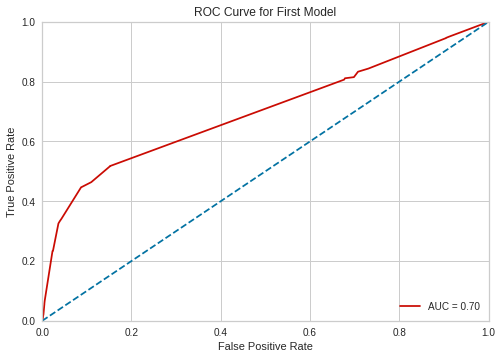

In [0]:
import sklearn.metrics as metrics

probs = val_model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve for First Model')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
plt.savefig('roc_first_model.png', format='png', dpi=1200)

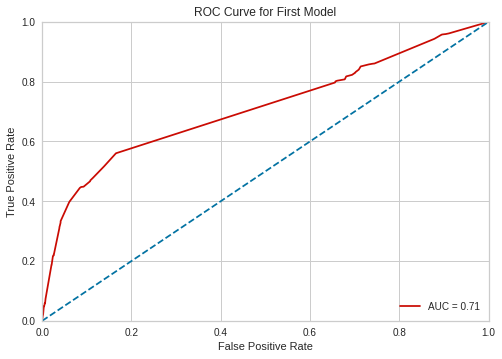

In [0]:
probs = val_model_2.predict_proba(x_test_2)
preds_2 = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_2, preds_2)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve for First Model')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
plt.savefig('roc_second_model.png', format='png', dpi=1200)

# K-Fold Cross Validation with Models

## Decision Tree Model

In [0]:
A = df.drop('Default', axis = 1)
b = df['Default']

In [0]:
from sklearn.tree import DecisionTreeClassifier
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=2)

dtree = DecisionTreeClassifier(random_state=2, min_samples_leaf=5, min_samples_split=20)

dtree.fit(A_train, b_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2, splitter='best')

In [0]:
dmodel = dtree
accuracy2 = cross_val_score(dmodel, A, b, scoring='accuracy', cv = 10)

In [0]:
print('Accuracy of Decision Tree Model with Cross Validation is:', accuracy2.mean() * 100)

Accuracy of Decision Tree Model with Cross Validation is: 76.41666666666667


## Random Forest Model

In [0]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(random_state=2)
model3 = rforest
accuracy3 = cross_val_score(model3, A, b, scoring='accuracy', cv = 10)
print('Accuracy of Random Forest Model with Cross Validation is:', accuracy3.mean() * 100)

Accuracy of Random Forest Model with Cross Validation is: 81.57


In [0]:
accuracy7 = cross_val_score(model3, A, b, scoring='accuracy', cv = 5)
print('Accuracy of Random Forest Model with Cross Validation is:', accuracy7.mean() * 100)

Accuracy of Random Forest Model with Cross Validation is: 81.57666666666668


 Random Forest Feature Importances

In [0]:
rforest.fit(A_train, b_train)
rforest.feature_importances_

array([0.05810638, 0.01233079, 0.02079707, 0.01412026, 0.06711819,
       0.09594477, 0.04336445, 0.02796251, 0.02213359, 0.02200953,
       0.01931691, 0.06077577, 0.0547723 , 0.05208551, 0.04990766,
       0.05028204, 0.05077199, 0.05051841, 0.04861898, 0.04596849,
       0.04295758, 0.04410595, 0.04603084])

In [0]:
importance = pd.DataFrame({'Importance': rforest.feature_importances_}, index=A_train.columns).sort_values('Importance', ascending = False)
importance

,Importance
PAY_0,0.095945
AGE,0.067118
BILL_AMT1,0.060776
LIMIT_BAL,0.058106
BILL_AMT2,0.054772
BILL_AMT3,0.052086
BILL_AMT6,0.050772
PAY_AMT1,0.050518
BILL_AMT5,0.050282
BILL_AMT4,0.049908


## Random Forest Model from GridSearch

In [0]:
from sklearn.metrics import accuracy_score

best = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

best.fit(A_train, b_train)
accuracy_score(b_test, best.predict(A_test))


0.823

In [0]:
rf_accuracy = cross_val_score(best, A, b, scoring='accuracy', cv = 10)
print('Accuracy of Best Random Forest Model with Cross Validation is:', rf_accuracy.mean() * 100)

Accuracy of Best Random Forest Model with Cross Validation is: 82.10333333333332


Best Random Forest Model Feature Importances

In [0]:
best.feature_importances_
importance1 = pd.DataFrame({'Importance': best.feature_importances_}, index=A_train.columns).sort_values('Importance', ascending = False)
importance1

,Importance
PAY_0,0.277992
PAY_2,0.144884
PAY_3,0.084333
PAY_4,0.070161
PAY_6,0.045338
PAY_5,0.042025
PAY_AMT1,0.033853
LIMIT_BAL,0.032905
PAY_AMT2,0.028214
BILL_AMT1,0.027354


In [0]:
import plotly.express as px
fig1 = px.bar(importance1, x=importance1.index, y = 'Importance', labels={'x':'Feature'})
fig1.show()

## Random Forest Model with Significant Features

In [0]:
cd = df[['PAY_0', 'PAY_2', 'PAY_3']]
B= b

In [0]:
accuracy3 = cross_val_score(model3, cd, B, scoring='accuracy', cv = 10)
print('Accuracy of Random Forest Model with Cross Validation is:', accuracy3.mean() * 100)

Accuracy of Random Forest Model with Cross Validation is: 82.01333333333332


In [0]:
rf_accuracy = cross_val_score(best, cd, B, scoring='accuracy', cv = 10)
print('Accuracy of Best Random Forest Model with Cross Validation is:', rf_accuracy.mean() * 100)

Accuracy of Best Random Forest Model with Cross Validation is: 82.02666666666667


## Recursive Feature Elimination with Cross Validation

In [0]:
from sklearn.feature_selection import RFECV

rfe = RFECV(best, 3)
fit = rfe.fit(A, b)

rfe_predictions = rfe.predict(A_test)

In [0]:
rfe.score(A_test, b_test)

0.8378333333333333

In [0]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(10)
visualizer = RFECV(best, cv=cv, scoring='f1_weighted')

visualizer.fit(A, b)        

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=8, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='f1_weighted', step=1,
      verbose=0)

In [0]:
visualizer.score(A_test, b_test)

0.834

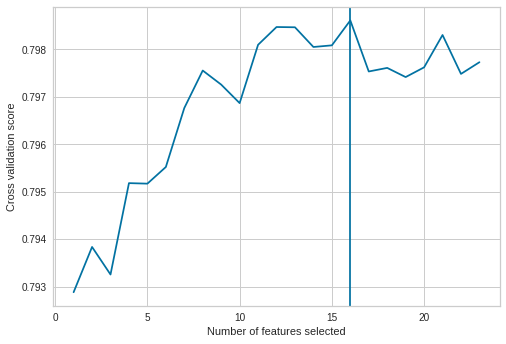

In [0]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(visualizer.grid_scores_) + 1), visualizer.grid_scores_)
plt.axvline(x=16)
plt.show()

## Random Forest Grid Searches

In [0]:
from sklearn.model_selection import GridSearchCV 
param_grid = { 
    'n_features_to_select': [3,4,5,6,7,8,9,10]}

grid1 = GridSearchCV(estimator = rfe, param_grid=param_grid, 
                          cv = 5, verbose = 51, n_jobs=-1)

import time
t_start = time.time()
grid1.fit(A_train, b_train)
t_end = time.time()

In [0]:
best1 = grid1.best_estimator_
best1.fit(A_train, b_train)
accuracy_score(y_test, best1.predict(A_test))

In [0]:
cd_train, cd_test, B_train, B_test = train_test_split(cd, B, test_size=0.2, random_state=2)


from sklearn.model_selection import GridSearchCV 

max_depth = list(np.arange(1,10))
max_depth.append(None)
param_grid = { 
    'max_depth': max_depth,
    'n_estimators': np.arange(100, 1100, 200), 
    'min_samples_split': [2,4,8,16],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid = GridSearchCV(estimator = rf, param_grid=param_grid, 
                          cv = 3, verbose = 51, n_jobs=-1)

import time
t_start = time.time()
grid.fit(cd_train, Y_train)
t_end = time.time()

In [0]:
best = grid.best_estimator_
best.fit(cd_train, B_train)
accuracy_score(B_test, best.predict(cd_test))